In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

In [2]:
from llmcoder.utils import get_data_dir

In [3]:
# Search for analysis results in the data directory
EVAL_CURATED_DIR = get_data_dir('LLMcoder-Eval/eval_curated')
GITHUB_MIX_DIR = get_data_dir('LLMcoder-Eval/github_mix')

In [4]:
# Read the results (json files of the format "results_[config_name}_%Y-%m-%d_%H-%M-%S.json") into a dict
def read_results(results_dir):
    results = {}
    for filename in os.listdir(results_dir):
        if filename.startswith('results_') and filename.endswith('.json'):
            with open(os.path.join(results_dir, filename)) as f:
                results[os.path.splitext(filename)[0]] = json.load(f)
    return results

In [5]:
# Read the analysis results (csv files of the format "results_[config_name}_%Y-%m-%d_%H-%M-%S.csv") into a pandas dataframe
def read_analysis_results(results_dir):
    results = []
    for filename in os.listdir(results_dir):
        if filename.startswith('results_') and filename.endswith('.csv'):
            df = pd.read_csv(os.path.join(results_dir, filename), index_col=0)
            df['config_name'] = filename
            results.append(df)
    return pd.concat(results)

In [6]:
def get_all_results(results_dirs):
    results = {}
    for results_dir in results_dirs:
        results.update(read_results(results_dir))
    return results

def get_all_analysis_results(results_dirs):
    results = []
    for results_dir in results_dirs:
        results.append(read_analysis_results(results_dir))
    return pd.concat(results)

In [7]:
results = {
    'eval_curated': read_results(EVAL_CURATED_DIR),
    'github_mix': read_results(GITHUB_MIX_DIR)
}

analysis_results = {
    'eval_curated': read_analysis_results(EVAL_CURATED_DIR),
    'github_mix': read_analysis_results(GITHUB_MIX_DIR)
}

In [8]:
analysis_results['eval_curated'].head()

,levenshtein_distance_score,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,config_name
0,1728,0.086455,0.426736,0.059135,1.0,0,588,0,results_plain_eval-curated_2023-12-01_18-09-08...
1,84,0.060156,0.484596,0.141414,2.0,0,163,0,results_plain_eval-curated_2023-12-01_18-09-08...
2,3263,0.000047,0.763331,0.013832,0.0,0,448,0,results_plain_eval-curated_2023-12-01_18-09-08...
3,295,0.386135,0.711452,0.012422,1.0,0,315,0,results_plain_eval-curated_2023-12-01_18-09-08...
4,809,0.020719,0.464121,0.002356,5.0,0,386,0,results_plain_eval-curated_2023-12-01_18-09-08...


In [9]:
analysis_results['eval_curated']['log_levenshtein_distance_score'] = np.log10(analysis_results['eval_curated']['levenshtein_distance_score'] + 1)
analysis_results['github_mix']['log_levenshtein_distance_score'] = np.log10(analysis_results['github_mix']['levenshtein_distance_score'] + 1)

# Remove the regular levenshtein_distance_score
analysis_results['eval_curated'].drop(columns=['levenshtein_distance_score'], inplace=True)
analysis_results['github_mix'].drop(columns=['levenshtein_distance_score'], inplace=True)

In [10]:
# Get the minimum and maximum of each column endind with "_score"
def get_min_max_scores(df):
    return df.filter(regex='_score$').agg(['min', 'max']).transpose()

In [11]:
def scores_histogram(analysis_results):
    min_max_scores = get_min_max_scores(analysis_results)
    min_max_scores

    # Create a histogram of each score for each config
    # The configs are the rows and the scores are the columns

    unique_configs = sorted(analysis_results['config_name'].unique())
    unique_scores = [score for score in analysis_results.columns if score.endswith('_score')]
    
    fig, axes = plt.subplots(len(unique_configs), len(unique_scores), figsize=(len(unique_scores) * 3, len(unique_configs) * 2), dpi=100)

    axes = np.array(axes).reshape(len(unique_configs), len(unique_scores))

    for i, score in enumerate(unique_scores):
        for j, config in enumerate(unique_configs):
            config_name_reduced = config.replace('results_', '')
            config_name_reduced = config_name_reduced[:config_name_reduced.find('2023') - 1]

            axes[j, i].hist(analysis_results[analysis_results['config_name'] == config][score], bins=np.linspace(min_max_scores.loc[score, 'min'], min_max_scores.loc[score, 'max'], 20), label=config_name_reduced if i == 0 else None)
            axes[j, i].set_title(f'{score}')

            # Plot the median
            axes[j, i].axvline(analysis_results[analysis_results['config_name'] == config][score].median(), color='tab:red', label='median')

            if i == 0:
                axes[j, i].legend()

    fig.tight_layout()

    return fig, axes

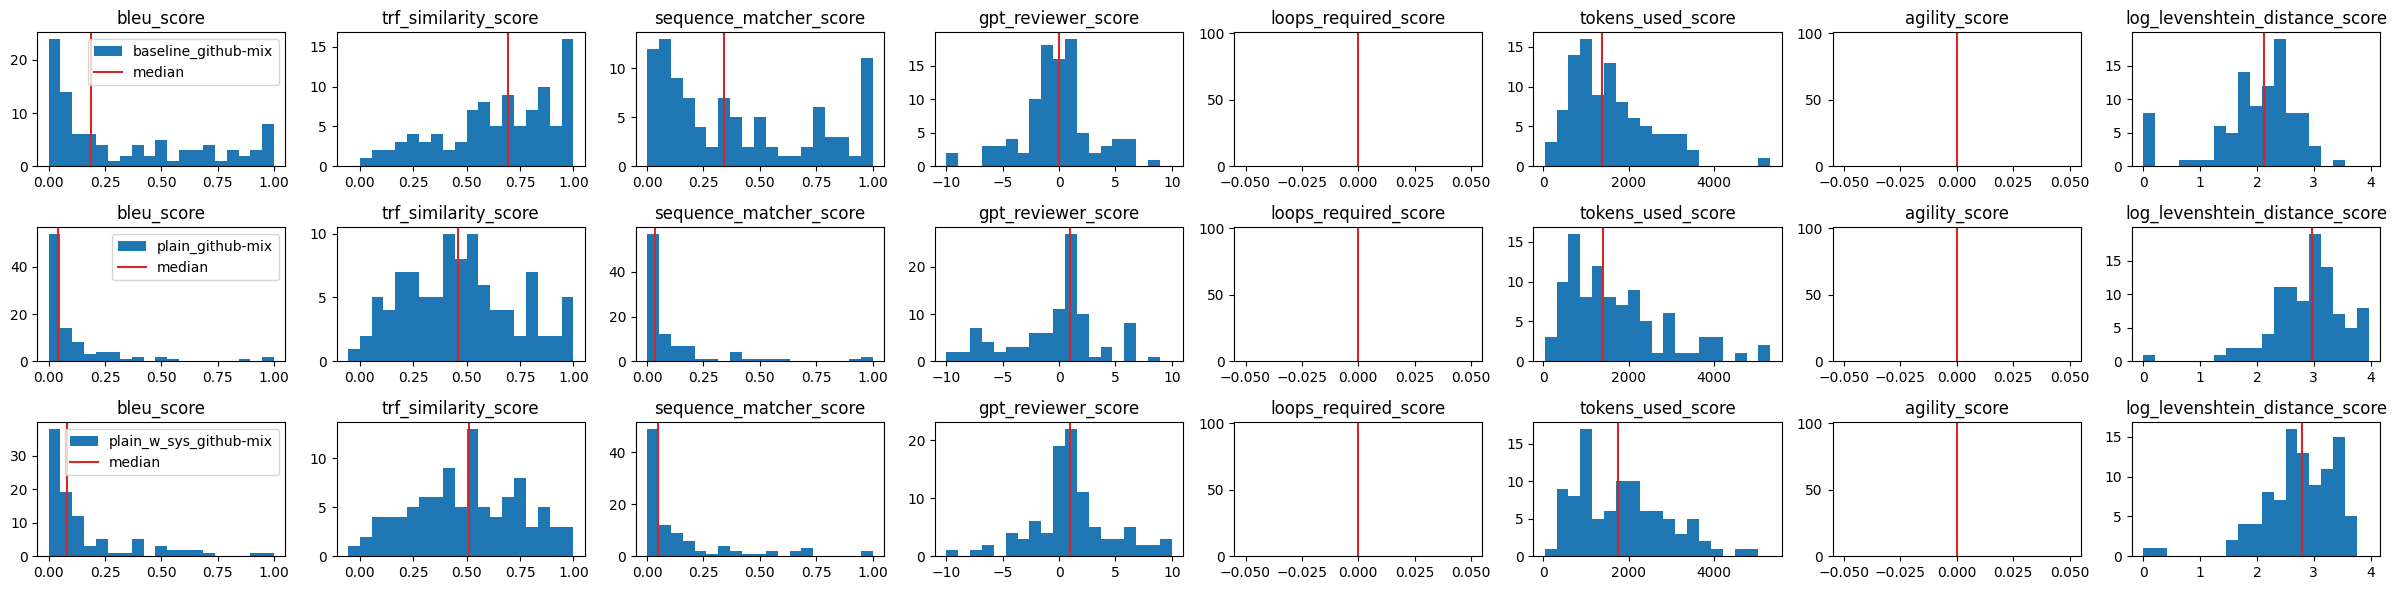

In [12]:
fig, axes = scores_histogram(analysis_results['github_mix'])

# fig.savefig('github_mix_scores_histogram.svg', bbox_inches='tight')

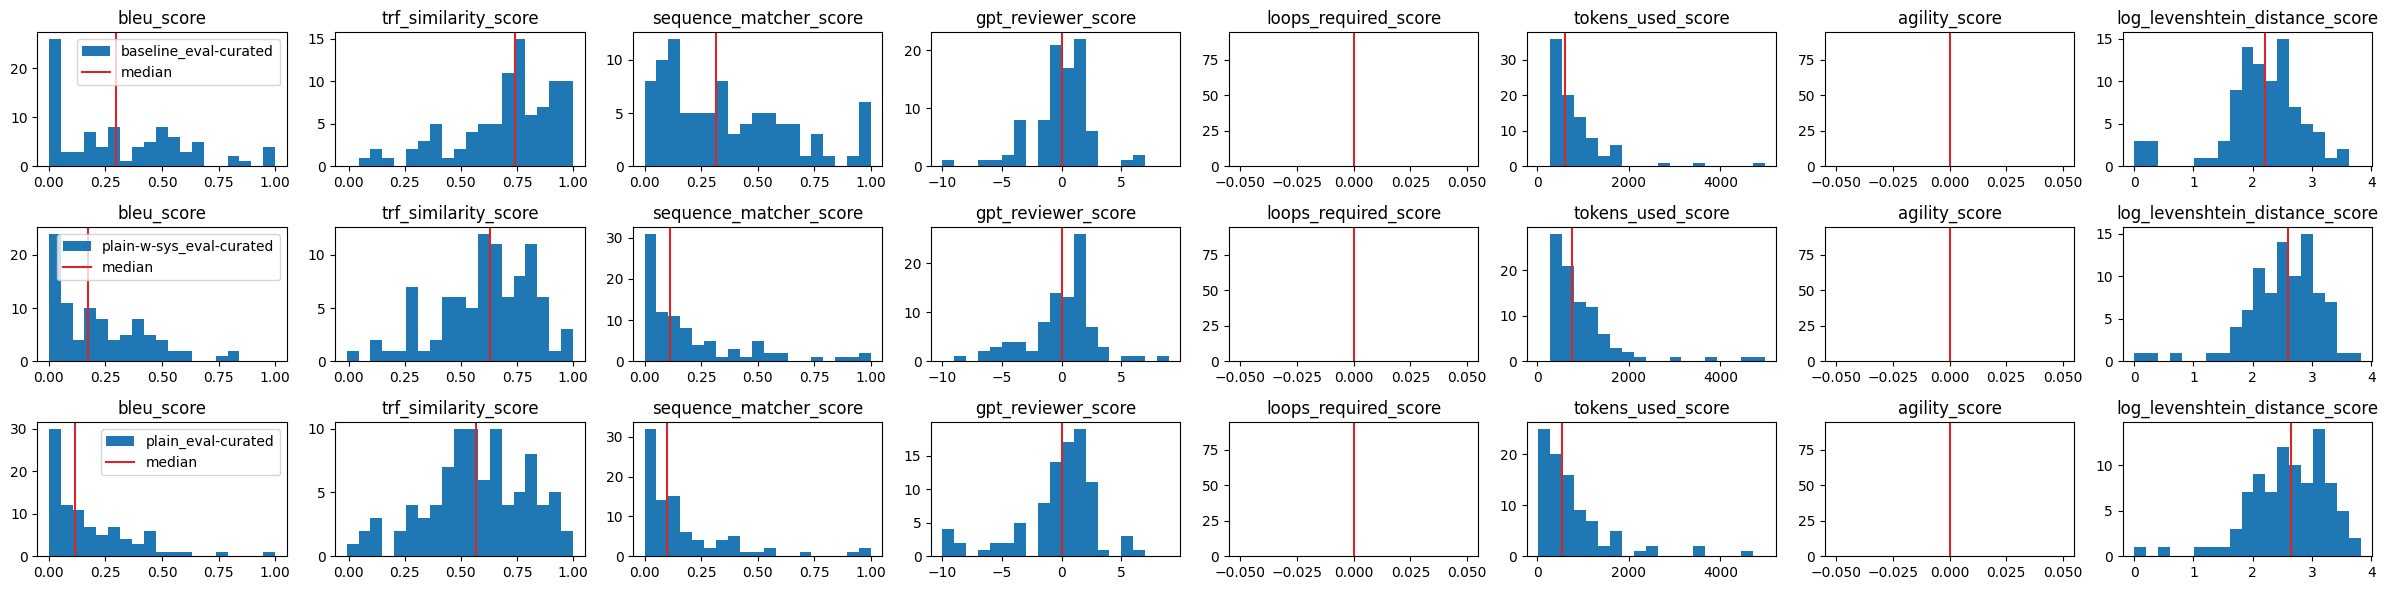

In [13]:
fig, axes = scores_histogram(analysis_results['eval_curated'])

# fig.savefig('eval_curated_scores_histogram.png')

In [24]:
criterion = "trf_similarity_score"

In [25]:
# Print the rows with the worst sequence matcher scores (10) for the baseline_evaol_cureated config
analysis_results['eval_curated'][
    (analysis_results['eval_curated'][criterion] < 0.5)
    & (analysis_results['eval_curated']['config_name'] == "results_baseline_eval-curated_2023-12-01_15-16-45.csv")
].sort_values(criterion, ascending=True).head(10)

,bleu_score,trf_similarity_score,sequence_matcher_score,gpt_reviewer_score,loops_required_score,tokens_used_score,agility_score,config_name,log_levenshtein_distance_score
33,5.316206e-05,0.068287,0.143646,-2.0,0,752,0,results_baseline_eval-curated_2023-12-01_15-16...,2.184691
88,1.579514e-160,0.120774,0.071429,0.0,0,301,0,results_baseline_eval-curated_2023-12-01_15-16...,2.093422
64,1.633226e-187,0.122985,0.006987,-10.0,0,917,0,results_baseline_eval-curated_2023-12-01_15-16...,3.356790
3,9.283871e-242,0.196346,0.031128,2.0,0,466,0,results_baseline_eval-curated_2023-12-01_15-16...,2.378398
0,6.117574e-04,0.292012,0.127072,-4.0,0,430,0,results_baseline_eval-curated_2023-12-01_15-16...,2.468347
84,1.016693e-78,0.304742,0.107143,6.0,0,329,0,results_baseline_eval-curated_2023-12-01_15-16...,1.690196
4,1.065111e-78,0.312171,0.155689,6.0,0,472,0,results_baseline_eval-curated_2023-12-01_15-16...,2.120574
73,6.290620e-79,0.322758,0.346154,-4.0,0,323,0,results_baseline_eval-curated_2023-12-01_15-16...,1.491362
26,8.049851e-13,0.344397,0.048974,-4.0,0,423,0,results_baseline_eval-curated_2023-12-01_15-16...,3.451018
17,3.527864e-08,0.364160,0.100437,-4.0,0,374,0,results_baseline_eval-curated_2023-12-01_15-16...,2.614897


In [26]:
results['eval_curated']['results_baseline_eval-curated_2023-12-01_15-16-45'].keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89'])

In [27]:
import json
import os
# from rich.jupyter import print

from llmcoder.utils import get_data_dir

In [28]:
DATA_DIR = get_data_dir('LLMcoder-Eval/eval_curated')
print(DATA_DIR)

/home/psaegert/Projects/23ws-LLMcoder/data/LLMcoder-Eval/eval_curated


In [29]:
# Define the ground truth
GROUND_TRUTH_FILE = "conversations.jsonl"

In [30]:
# Load the inputs and ground truth from the ground truth file
with open(os.path.join(DATA_DIR, GROUND_TRUTH_FILE), "r") as f:
    ground_truth_file = [json.loads(line) for line in f.readlines()]

# Extract the input code and ground truth from the ground truth file
# The ground truth file is a list of conversations
# The input is the message with "role": "user"
# The ground truth is the message with "tole": "assistant"

inputs = []
ground_truths = []
for conversation in ground_truth_file:
    for message in conversation['messages']:
        if message["role"] == "user":
            inputs.append(message["content"])
        elif message["role"] == "assistant":
            ground_truths.append(message["content"])

print(f'Inputs: {len(inputs)}')
print(f'Ground truth: {len(ground_truths)}')

Inputs: 90
Ground truth: 90


In [33]:
# Show the best results
for i, row in analysis_results['eval_curated'][
    (analysis_results['eval_curated'][criterion] < 0.5)
    & (analysis_results['eval_curated']['config_name'] == "results_baseline_eval-curated_2023-12-01_15-16-45.csv")
].sort_values(criterion, ascending=False).head(20).iterrows():
    # Get the corresponding result
    result = results['eval_curated']['results_baseline_eval-curated_2023-12-01_15-16-45'][f'{i}']
    for message in result['messages'][1:]:
        print(f"{message['role'].upper()}:\n{message['content']}")

    ground_truth = ground_truths[i]

    print("GROUND TRUTH:")
    print(ground_truth)

    print(f"{criterion}: {row[criterion]}")
    print("-" * 80)

USER:
def get_document_info_page(url):
    """
    Get the redirected url from a given url

    Example:
    https://eur-lex.europa.eu/legal-content/AUTO/?uri=CELEX:31983H0230&qid=1698155004044&rid=460 -> https://eur-lex.europa.eu/legal-content/EN/ALL/?uri=CELEX:31983H0230
    """

ASSISTANT:
    response = requests.get(url, allow_redirects=False)
    redirected_url = response.headers['Location']
    return redirected_url
GROUND TRUTH:
url = url.replace('AUTO', 'EN/ALL')
    return url[:url.find('&')]
trf_similarity_score: 0.4358039796352386
--------------------------------------------------------------------------------
USER:
from __future__ import annotations

import os
import time

from modules import timer
from modules import initialize_util
from modules import initialize

startup_timer = timer.startup_timer
startup_timer.record("launcher")

initialize.imports()

initialize.check_versions()


def create_api(app):
    from modules.api.api import Api
    from modules.call_queue impor